What is ACE?

The ACE program is a bus-mounted camera system that issues violations to vehicles occupying bus lanes, double parked vehicles along bus routes, and vehicles blocking bus stops. It is currently active on 39 bus routes that carry over 775K average weekday riders.


What is ACE’s goal?

ACE’s goal is to make bus service faster and more reliable by keeping bus lanes and bus stops clear.


Has ACE been achieving their goals?

Camera enforcement has sped up buses on the 39 targeted routes by an average of 5%, with some corridors seeing much larger gains of up to 30%

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import requests
import time
import concurrent.futures
import zipfile
import io
import glob
import folium
from tqdm import tqdm
from datetime import date

(1) Which MTA bus routes are highly utilized by CUNY students? For routes that are automated camera-enforced, how have bus speeds changed over time?



Recommendation - Compare a bus route you or someone you know utilizes for campus. Compare this with another campus route and a route that is not ACE enforced.

(2) Some vehicles stopped in violation are exempt from fines due to business reasons. For vehicles that are exempt, are there repeat offenders? Where are exempt vehicles frequently in violation?



Recommendation - This problem is great for a mapping visualization! Choose a CUNY bus route that you are familiar with plot the long and latitude of where vehicles are in violation as well as the overall bus route.

(3) Some automated camera-enforced routes travel within or cross Manhattan’s Central Business District. How have violations on these routes changed alongside the implementation of congestion pricing?



Recommendation - Another great problem to share a mapping visualization. Map CUNY Bus Routes that run through the CBD before and after congestion pricing to show change in bus speeds.

In [2]:
ace_violation_ds = pd.read_csv("MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250917.csv")
ace_violation_ds.columns


Index(['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence',
       'Violation Status', 'Violation Type', 'Bus Route ID',
       'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name',
       'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference',
       'Bus Stop Georeference'],
      dtype='object')

In [3]:
ace_violation_ds.head()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076)
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487)
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)


In [4]:
ace_violation_ds.tail()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
3778563,215529785,7c86bc81ee2cc6902d3588132fb15c13a61e2d53bb379f...,10/07/2019 07:14:15 AM,10/07/2019 09:32:52 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS LANE,M15+,40.736718,-73.981533,401779,2 AV/E 23 ST,40.737516,-73.981202,POINT (-73.98153283 40.736718),POINT (-73.981202 40.737516)
3778564,215529313,NaN,10/07/2019 07:46:17 AM,10/07/2019 08:59:26 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.783963,-73.947290,405347,2 AV/E 106 ST,40.790860,-73.942431,POINT (-73.9472905 40.78396317),POINT (-73.942431 40.79086)
3778565,215529148,981a9958b7d133d4181bab81f397b32743a3c9512d36df...,10/07/2019 08:48:22 AM,10/07/2019 09:02:04 AM,VIOLATION ISSUED,MOBILE BUS LANE,M15+,40.801421,-73.934522,401738,2 AV/E 125 ST,40.802473,-73.933855,POINT (-73.93452183 40.801421),POINT (-73.933855 40.802473)
3778566,215520437,NaN,10/07/2019 09:31:50 AM,10/07/2019 09:46:58 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.758721,-73.965715,401765,2 AV/E 57 ST,40.758987,-73.965601,POINT (-73.96571483 40.758721),POINT (-73.965601 40.758987)
3778567,215520220,7b5f5c2b127271c84694812b5d9ef964042fdc9a437a10...,10/07/2019 09:16:01 AM,10/07/2019 09:28:13 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS LANE,M15+,40.783154,-73.947905,401749,2 AV/E 96 ST,40.783817,-73.947494,POINT (-73.94790483 40.783154),POINT (-73.947494 40.783817)


In [33]:
# Convert the 'First Occurrence' column to a proper datetime format accounting for 8/20/2022 to 8/20/2025
ace_violation_ds['First Occurrence'] = pd.to_datetime(ace_violation_ds['First Occurrence'])
start_date = '2022-01-01'
end_date = '2024-12-31'
filtered_df = ace_violation_ds[
    (ace_violation_ds['First Occurrence'] >= start_date) & 
    (ace_violation_ds['First Occurrence'] <= end_date)
]
sorted_df = filtered_df.sort_values(by='First Occurrence')
sorted_df.head()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
3538702,302418921,62457604b49622dae3fe44b0a21846c5b31dca9ceb49c8...,2022-01-02 07:42:00,01/02/2022 10:09:00 AM,VIOLATION ISSUED,MOBILE BUS LANE,M15+,40.794488,-73.939594,405348,2 AV/E 115 ST,40.795919,-73.938770,POINT (-73.93959433 40.794488),POINT (-73.93877 40.795919)
3538705,302396677,f13f21602832553d73c27dadb056d038455d84c24bb07f...,2022-01-02 08:31:09,01/02/2022 09:33:55 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS LANE,M15+,40.758545,-73.962715,401701,1 AV/MITCHELL PL,40.753591,-73.966311,POINT (-73.96271467 40.75854517),POINT (-73.966311 40.753591)
3538704,302399543,329c9853689c163d187dd1a5d5c47a9be59673936cee11...,2022-01-02 09:25:25,01/02/2022 09:42:36 AM,DRIVER/VEHICLE INFO MISSING,MOBILE BUS LANE,M15+,40.786063,-73.942578,903102,1 AV/ E 97 ST,40.784225,-73.943936,POINT (-73.9425785 40.78606317),POINT (-73.943936 40.784225)
3538701,302419153,ff2a33c7507c9d86890d0d9e7e7ac38cccc92419133e0b...,2022-01-02 10:06:12,01/02/2022 11:20:39 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS LANE,M14+,40.732872,-73.985623,401191,E 14 ST/3 AV,40.733008,-73.986729,POINT (-73.9856225 40.7328725),POINT (-73.986729 40.733008)
3538699,302419206,6b384b49a0085a160c3fcae7b9186c9dabd0d43190d5b8...,2022-01-02 11:14:40,01/02/2022 11:20:36 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS LANE,M14+,40.732968,-73.985882,401191,E 14 ST/3 AV,40.733008,-73.986729,POINT (-73.98588183 40.73296783),POINT (-73.986729 40.733008)


In [34]:
sorted_df.tail()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
1678307,452232689,8c8c3903e4ee259558cc9b5b3d1fe4b9070da4bc7027d2...,2024-12-30 23:54:08,12/30/2024 11:59:08 PM,VIOLATION ISSUED,MOBILE BUS STOP,Q54,40.703632,-73.799539,501422,170 ST/JAMAICA AV,40.707549,-73.789882,POINT (-73.799539 40.703632),POINT (-73.789882 40.707549)
1682066,452138724,d30f3f77237b8b9f21e3891a085b0b6c86b567b1f88298...,2024-12-30 23:54:33,12/30/2024 11:57:56 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.651585,-74.004411,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-74.004411 40.651585),POINT (-74.007835 40.653699)
1682218,452138281,70a2a76a2aefca05055374daf60f348ad4df2d5ef963c8...,2024-12-30 23:55:38,12/30/2024 11:58:30 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.649806,-74.001468,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-74.001468 40.649806),POINT (-74.007835 40.653699)
1682231,452138182,9cfed6ec5ddbc3516b5d404fff8bcc369ccbf86d887e14...,2024-12-30 23:56:10,12/30/2024 11:59:11 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.648517,-73.999335,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-73.999335 40.648517),POINT (-74.007835 40.653699)
1677837,452235576,7f30cea65da8a1540bcf0640699b2cbc0ff2be727e3592...,2024-12-30 23:56:17,12/31/2024 10:25:16 PM,VIOLATION ISSUED,MOBILE BUS STOP,Q53+,40.745826,-73.900883,553332,ROOSEVELT AV/61 ST,40.745673,-73.902110,POINT (-73.900883 40.745826),POINT (-73.90211 40.745673)


In [35]:
sorted_df.to_pickle('filtered_mta_violations.pkl')

In [2]:
with open('filtered_mta_violations.pkl', 'rb') as f:
    sorted_df = pickle.load(f)

In [3]:
def bus_route_borough(route):
    if pd.isna(route):
        return 'Other'
    route_str = str(route).upper()

    if route_str.startswith(('BM', 'BXM', 'QM', 'SIM', 'X')):
        return 'Express / Cross-Borough'
    elif route_str.startswith('BX'):
        return 'BX (Bronx)'
    elif route_str.startswith('B'):
        return 'B (Brooklyn)'
    elif route_str.startswith('Q'):
        return 'Q (Queens)'
    elif route_str.startswith('M'):
        return 'M (Manhattan)'
    elif route_str.startswith('S'):
        return 'S (Staten Island)'
    else:
        return 'Other'


sorted_df['borough'] = sorted_df['Bus Route ID'].apply(bus_route_borough)
print(sorted_df['borough'].value_counts())
borough_count = sorted_df['borough'].value_counts()

borough
BX (Bronx)           746596
M (Manhattan)        450481
B (Brooklyn)         335891
Q (Queens)           278071
S (Staten Island)     39526
Other                 10619
Name: count, dtype: int64


In [4]:
column_name = "Bus Route ID"
express_mask = sorted_df[column_name].str.upper().str.startswith(('BM', 'BXM', 'QM', 'SIM', 'X'), na=False)
express_violations = sorted_df[express_mask]
print(f"Found {len(express_violations)} violations from express bus routes.")

Found 0 violations from express bus routes.


(np.float64(-1.099998981258781),
 np.float64(1.0999881835191196),
 np.float64(-1.0999927708170887),
 np.float64(1.0999982485727213))

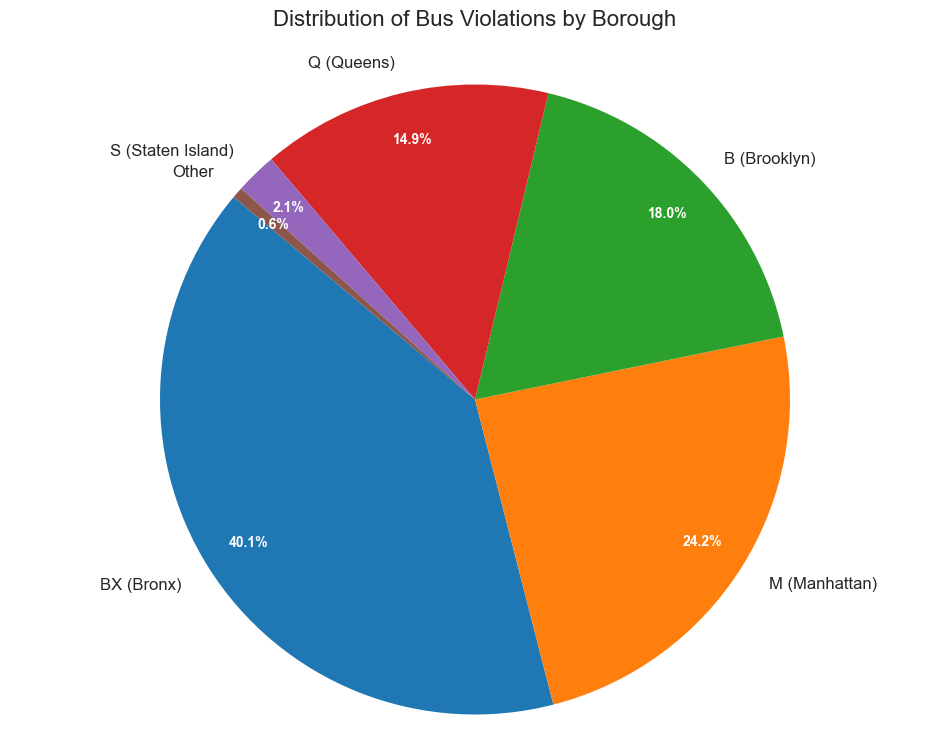

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 9))
wedges, texts, autotexts = plt.pie(
        borough_count, 
        labels=borough_count.index, 
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85,
        textprops={'fontsize': 12}
    )

plt.setp(autotexts, size=10, weight="bold", color="white")
plt.title('Distribution of Bus Violations by Borough', fontsize=16, pad=20)
plt.axis('equal')

In [24]:
sorted_df["Violation Status"].value_counts()

Violation Status
VIOLATION ISSUED                1230807
EXEMPT - EMERGENCY VEHICLE       127727
TECHNICAL ISSUE/OTHER            127003
DRIVER/VEHICLE INFO MISSING      120154
EXEMPT - COMMERCIAL UNDER 20     111798
EXEMPT - BUS/PARATRANSIT          85682
EXEMPT - OTHER                    58013
Name: count, dtype: int64

 Pulling MTA Bus Hourly Ridership: 2020-2024 but I just want 2022 to 2024

In [8]:
LIMIT = 50000
MAX_WORKERS = 10
BASE_URL = "https://data.ny.gov/resource/kv7t-n8in.json"
WHERE_CLAUSE = "transit_timestamp >= '2024-01-01' AND transit_timestamp <= '2024-12-31'"
OUTPUT_DIR = "ridership_chunks_final" # Directory to save temporary files

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Asking API for total record count...")
count_params = {'$where': WHERE_CLAUSE, '$select': 'count(*)'}
response = requests.get(BASE_URL, params=count_params)
total_records = int(response.json()[0]['count'])
total_pages = math.ceil(total_records / LIMIT)
print(f"Found {total_records:,} records in {total_pages} pages. Chunks will be saved to '{OUTPUT_DIR}/'")


def fetch_and_save_page(offset):
    """Fetches a single page of data, with retries, and saves it to a file."""
    params = {'$where': WHERE_CLAUSE, '$limit': LIMIT, '$offset': offset}
    # --- Retry Loop ---
    for attempt in range(3): # Try up to 3 times
        try:
            response = requests.get(BASE_URL, params=params, timeout=30) # Add a 30-second timeout
            response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
            data = response.json()
            if data:
                df_chunk = pd.DataFrame(data)
                df_chunk.to_parquet(f'{OUTPUT_DIR}/chunk_{offset}.parquet')
            return len(data) # Success
        except requests.exceptions.RequestException as e:
            # If an error occurs, wait 5 seconds before the next attempt
            time.sleep(5) 
    # If all attempts fail, this page is skipped.
    return 0 


offsets = [i * LIMIT for i in range(total_pages)]
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(tqdm(executor.map(fetch_and_save_page, offsets), total=total_pages, desc="Downloading and saving chunks"))

print(f"\nFinished downloading all chunks to the '{OUTPUT_DIR}' directory.")

Asking API for total record count...
Found 83,889,144 records in 1678 pages. Chunks will be saved to 'ridership_chunks_final/'



Finished downloading all chunks to the 'ridership_chunks_final' directory.


Convert to dataframe for ease of access

In [ ]:
pip install "dask[dataframe]" pyarrow

In [12]:
import dask.dataframe as dd

# Dask reads all the Parquet files in the directory as a single, virtual DataFrame
ridership = dd.read_parquet('ridership_chunks_final/')

print(f"Total rows in the dataset: {len(ridership)}")

ridership.head()

Total rows in the dataset: 83889144


,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
0,2024-01-01T00:00:00.000,S52,omny,OMNY - Full Fare,2,1
1,2024-01-01T00:00:00.000,S55,metrocard,OMNY - Students,0,0
2,2024-01-01T00:00:00.000,S89,metrocard,Metrocard - Other,0,0
3,2024-01-01T00:00:00.000,S89,metrocard,OMNY - Other,0,0
4,2024-01-01T00:00:00.000,S94,omny,OMNY - Full Fare,0,0


In [13]:
ridership.tail()

,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
39139,2024-12-31T00:00:00.000,X21,omny,Metrocard - Unlimited 7-Day,0,0
39140,2024-12-31T00:00:00.000,X3,omny,Metrocard - Full Fare,0,0
39141,2024-12-31T00:00:00.000,X31,metrocard,Metrocard - Unlimited 30-Day,0,0
39142,2024-12-31T00:00:00.000,X38,metrocard,Metrocard - Other,0,0
39143,2024-12-31T00:00:00.000,X68,omny,Metrocard - Students,0,0


In [16]:
count = ridership['fare_class_category'].value_counts()
final = count.compute()
print(final)

fare_class_category
OMNY - Seniors & Disability         6990762
Metrocard - Unlimited 7-Day         6990762
Metrocard - Fair Fare               6990762
Metrocard - Seniors & Disability    6990762
Metrocard - Unlimited 30-Day        6990762
Metrocard - Students                6990762
Metrocard - Other                   6990762
OMNY - Fair Fare                    6990762
OMNY - Students                     6990762
OMNY - Other                        6990762
Metrocard - Full Fare               6990762
OMNY - Full Fare                    6990762
Name: count, dtype: int64[pyarrow]


In [17]:
# Load just the first downloaded chunk into pandas
df_chunk = pd.read_parquet('ridership_chunks_final/chunk_0.parquet')

# Check the value counts for this single chunk
print("Value counts for a single chunk:")
print(df_chunk['fare_class_category'].value_counts())

Value counts for a single chunk:
fare_class_category
Metrocard - Students                4187
OMNY - Other                        4182
Metrocard - Full Fare               4179
OMNY - Students                     4172
Metrocard - Unlimited 7-Day         4172
OMNY - Fair Fare                    4171
Metrocard - Seniors & Disability    4167
OMNY - Seniors & Disability         4160
Metrocard - Fair Fare               4160
Metrocard - Other                   4159
Metrocard - Unlimited 30-Day        4153
OMNY - Full Fare                    4138
Name: count, dtype: int64


In [20]:
# Load just the first downloaded chunk into pandas
df_chunk = pd.read_parquet('ridership_chunks_final/chunk_50000.parquet')

# Check the value counts for this single chunk
print("Value counts for a single chunk:")
print(df_chunk['fare_class_category'].value_counts())

Value counts for a single chunk:
fare_class_category
OMNY - Full Fare                    4207
OMNY - Seniors & Disability         4196
OMNY - Fair Fare                    4186
Metrocard - Seniors & Disability    4185
Metrocard - Fair Fare               4180
Metrocard - Unlimited 30-Day        4173
OMNY - Students                     4171
Metrocard - Other                   4162
Metrocard - Full Fare               4155
Metrocard - Unlimited 7-Day         4144
OMNY - Other                        4137
Metrocard - Students                4104
Name: count, dtype: int64



--- Hourly Ridership Counts ---
transit_timestamp
0     9528
1     9528
2     9528
3     9528
4     9528
5     9528
6     9528
7     9528
8     9528
9     9528
10    9528
11    9528
12    9528
13    9528
14    9528
15    9528
16    9528
17    9528
18    9528
19    9528
20    9528
21    9528
22    9528
23    9528
Name: count, dtype: int64

Generating plot...
Plot saved as 'hourly_ridership_pattern.png'


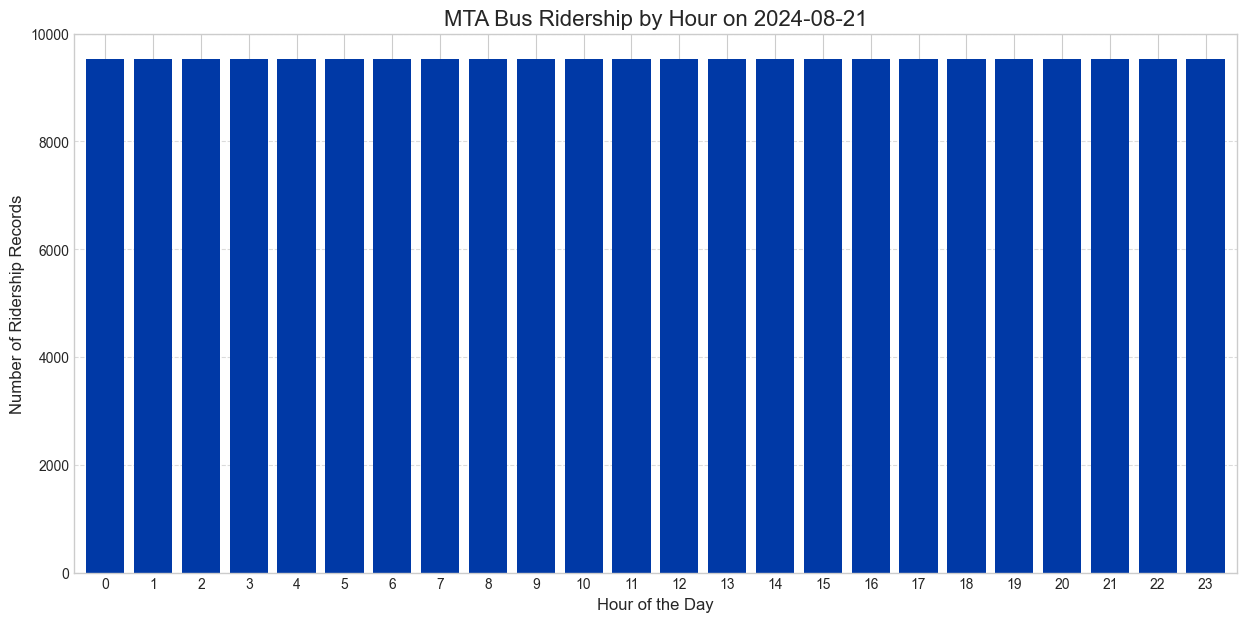

In [23]:
TARGET_DATE = '2024-08-21'

if ridership is not None:
    ridership['transit_timestamp'] = dd.to_datetime(ridership['transit_timestamp'])
    day_filter = (ridership['transit_timestamp'].dt.date == pd.to_datetime(TARGET_DATE).date())
    single_day_ddf = ridership[day_filter]
    hourly_counts = single_day_ddf['transit_timestamp'].dt.hour.value_counts().compute()

    # 4. Sort the results by hour for plotting
    hourly_counts = hourly_counts.sort_index()
    
    print("\n--- Hourly Ridership Counts ---")
    print(hourly_counts)

    # --- Plotting ---
    print("\nGenerating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    
    hourly_counts.plot(kind='bar', color='#0039A6', width=0.8)
    
    plt.title(f'MTA Bus Ridership by Hour on {TARGET_DATE}', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=12)
    plt.ylabel('Number of Ridership Records', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the plot to a file
    plt.savefig('hourly_ridership_pattern.png', bbox_inches='tight')
    print("Plot saved as 'hourly_ridership_pattern.png'")


synthetic or placeholder data possibly. This dataset is flawed??? Not live/real dataset?

(1) Which MTA bus routes are highly utilized by CUNY students? For routes that are automated camera-enforced, how have bus speeds changed over time?

Using MTA Bus Hourly Ridership: 2020-2024 and MTA General Transit Feed Specification (GTFS) Static Data for the first initial question on CUNY Students. (But might not be able to filter correctly since student metrocards are more for students)

MTA Bus Route Segment Speeds: 2023 - 2024 and MTA Bus Automated Camera Enforced Routes to answer change over time.
https://data.ny.gov/resource/58t6-89vi.json  (Bus Route Segment Speeds)
https://data.ny.gov/resource/ki2b-sg5y.json  (Camera Enforced Routes)


Uh their website not working and there isn't a single zip file for all so manually combining them

In [26]:
# A dictionary of the direct URLs for each GTFS file
GTFS_URLS = {
    "bronx": "http://web.mta.info/developers/data/nyct/bus/google_transit_bronx.zip",
    "brooklyn": "http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip",
    "manhattan": "http://web.mta.info/developers/data/nyct/bus/google_transit_manhattan.zip",
    "queens": "http://web.mta.info/developers/data/nyct/bus/google_transit_queens.zip",
    "staten_island": "http://web.mta.info/developers/data/nyct/bus/google_transit_staten_island.zip",
    "bus_company": "http://web.mta.info/developers/data/nyct/bus/google_transit_bus_company.zip"
}

# Create a main directory to hold all our GTFS data
output_dir = "gtfs_all"
os.makedirs(output_dir, exist_ok=True)

print("Downloading and unzipping all GTFS files...")
for name, url in GTFS_URLS.items():
    try:
        response = requests.get(url)
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            borough_dir = os.path.join(output_dir, name)
            z.extractall(borough_dir)
            print(f" - Successfully downloaded and unzipped data for {name}.")
    except Exception as e:
        print(f" - Failed to download or unzip for {name}. Error: {e}")

print("\nAll GTFS data has been downloaded.")

 - Successfully downloaded and unzipped data for bronx.
 - Successfully downloaded and unzipped data for brooklyn.
 - Successfully downloaded and unzipped data for manhattan.
 - Successfully downloaded and unzipped data for queens.
 - Successfully downloaded and unzipped data for staten_island.
 - Failed to download or unzip for bus_company. Error: File is not a zip file

All GTFS data has been downloaded.


In [28]:
def combine_gtfs_files(filename):
    all_files = glob.glob(f'{output_dir}/*/{filename}')
    df_list = []
    for f in all_files:
        try:
            df = pd.read_csv(f)
            df_list.append(df)
        except FileNotFoundError:
            # This handles cases where a file might be missing from one of the zips
            print(f"Warning: {filename} not found in {os.path.dirname(f)}")
    
    # Concatenate all the dataframes into one
    return pd.concat(df_list, ignore_index=True)

# Create the master DataFrames for the files we need
print("\nCombining GTFS files into master DataFrames...")
stops_df = combine_gtfs_files('stops.txt')
stop_times_df = combine_gtfs_files('stop_times.txt')
trips_df = combine_gtfs_files('trips.txt')
routes_df = combine_gtfs_files('routes.txt')

print("Master DataFrames created successfully.")
print(f"Total unique stops found across all boroughs: {stops_df['stop_id'].nunique()}")


Combining GTFS files into master DataFrames...
Master DataFrames created successfully.
Total unique stops found across all boroughs: 11523


In [29]:
processed_gtfs_dir = "gtfs_processed"
os.makedirs(processed_gtfs_dir, exist_ok=True)

# Save each DataFrame to its own Parquet file
stops_df.to_parquet(f'{processed_gtfs_dir}/stops.parquet')
stop_times_df.to_parquet(f'{processed_gtfs_dir}/stop_times.parquet')
trips_df.to_parquet(f'{processed_gtfs_dir}/trips.parquet')
routes_df.to_parquet(f'{processed_gtfs_dir}/routes.parquet')

print("All combined GTFS DataFrames have been saved.")

All combined GTFS DataFrames have been saved.


In [ ]:
processed_gtfs_dir = "gtfs_processed"

# Load the DataFrames directly from your saved files
stops_df = pd.read_parquet(f'{processed_gtfs_dir}/stops.parquet')
stop_times_df = pd.read_parquet(f'{processed_gtfs_dir}/stop_times.parquet')
trips_df = pd.read_parquet(f'{processed_gtfs_dir}/trips.parquet')
routes_df = pd.read_parquet(f'{processed_gtfs_dir}/routes.parquet')

print("Successfully loaded all processed GTFS DataFrames from local files.")
print(f"Loaded {len(stops_df)} total stops.")

In [30]:
CUNY_LOCATIONS = {
    'Baruch College': {'lat': 40.7404, 'lon': -73.9835},
    'Hunter College': {'lat': 40.7685, 'lon': -73.9657},
    'City College': {'lat': 40.8200, 'lon': -73.9493},
    'Queens College': {'lat': 40.7369, 'lon': -73.8188},
    'Brooklyn College': {'lat': 40.6309, 'lon': -73.9546}
}

# Helper function to calculate distance between two lat/lon points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Find all stops within a 0.4 km radius of any CUNY campus
nearby_stop_ids = set()
WALKING_DISTANCE_KM = 0.4

for campus, coords in CUNY_LOCATIONS.items():
    distances = haversine_distance(coords['lat'], coords['lon'], stops_df['stop_lat'], stops_df['stop_lon'])
    nearby_stops = stops_df[distances <= WALKING_DISTANCE_KM]
    nearby_stop_ids.update(nearby_stops['stop_id'])
    print(f"Found {len(nearby_stops)} stops near {campus}.")

print(f"\nTotal unique bus stops found near CUNY campuses: {len(nearby_stop_ids)}")

Found 38 stops near Baruch College.
Found 30 stops near Hunter College.
Found 24 stops near City College.
Found 2 stops near Queens College.
Found 13 stops near Brooklyn College.

Total unique bus stops found near CUNY campuses: 92


In [32]:
# Filter stop_times for our nearby stops to get the relevant trips
cuny_stop_times = stop_times_df[stop_times_df['stop_id'].isin(nearby_stop_ids)]

#Use those trip_ids to get the relevant routes
cuny_trips = trips_df[trips_df['trip_id'].isin(cuny_stop_times['trip_id'])]

# Use those route_ids to get the final route names
cuny_routes_info = routes_df[routes_df['route_id'].isin(cuny_trips['route_id'])]

# Create our final, unique list of CUNY-serving bus route names
cuny_route_names = cuny_routes_info['route_short_name'].unique().tolist()

print(f"\nFound {len(cuny_route_names)} unique bus routes that serve CUNY campuses.")


Found 40 unique bus routes that serve CUNY campuses.


In [35]:
ridership.columns

Index(['transit_timestamp', 'bus_route', 'payment_method',
       'fare_class_category', 'ridership', 'transfers'],
      dtype='object')

In [44]:
# Filter for rows where the bus route is in our list of CUNY-serving routes
ridership['ridership'] = ridership['ridership'].astype(float)
cuny_ridership_ddf = ridership[ridership['bus_route'].isin(cuny_route_names)]

# Group by bus route and sum the ridership for the entire period
# Use a specific, real year like 2023 to avoid synthetic data
cuny_ridership_ddf_2024 = cuny_ridership_ddf[cuny_ridership_ddf['transit_timestamp'].dt.year == 2024]
top_cuny_routes = cuny_ridership_ddf_2024.groupby('bus_route')['ridership'].sum().compute()

# Sort the results to see the most utilized routes
top_cuny_routes = top_cuny_routes.sort_values(ascending=False)

print("\n--- Top 15 Most Utilized Bus Routes Serving CUNY Campuses (2024 Ridership) ---")
print(top_cuny_routes.head(15))


--- Top 15 Most Utilized Bus Routes Serving CUNY Campuses (2024 Ridership) ---
bus_route
B6      5312856.0
M15     4241205.0
M101    4189363.0
M4      3517546.0
M3      2835170.0
M11     2683483.0
M102    2620425.0
M1      2550732.0
Q88     2404215.0
M103    2326089.0
M2      2035420.0
B49     2002936.0
B11     1991865.0
M66     1721046.0
M100    1620507.0
Name: ridership, dtype: float64



Chart saved as 'top_cuny_routes.png'


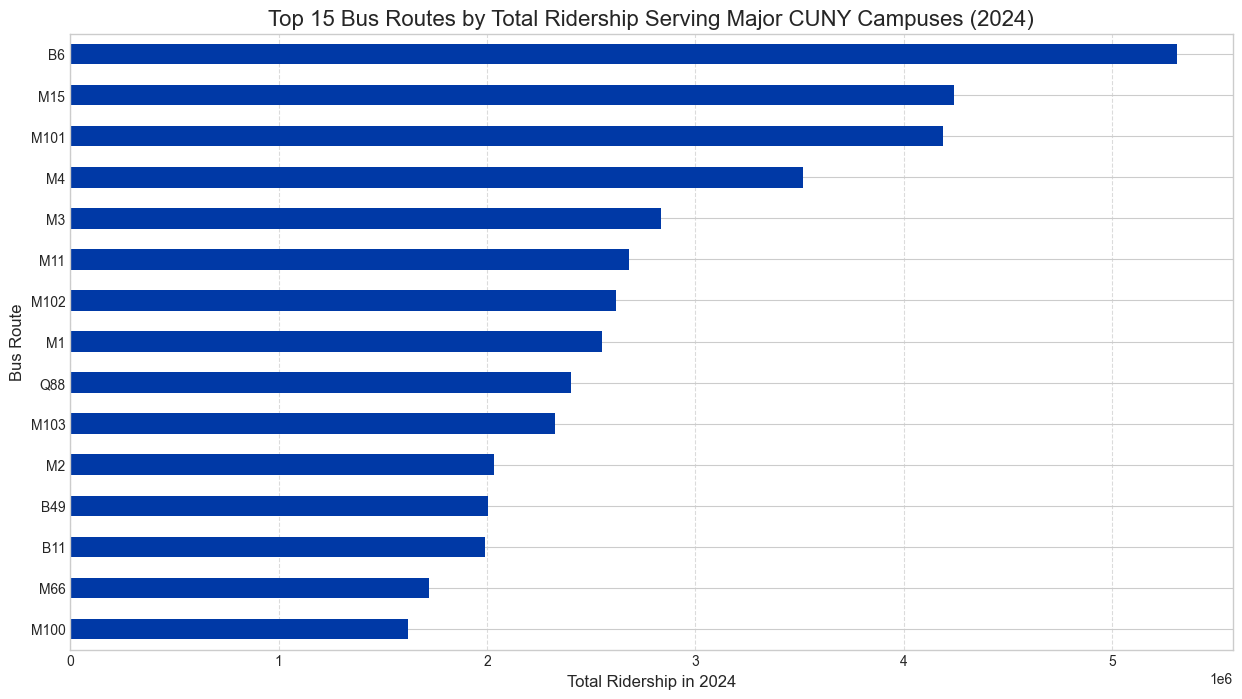

In [43]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))

top_cuny_routes.head(15).sort_values().plot(kind='barh', color='#0039A6')

plt.title('Top 15 Bus Routes by Total Ridership Serving Major CUNY Campuses (2024)', fontsize=16)
plt.xlabel('Total Ridership in 2024', fontsize=12)
plt.ylabel('Bus Route', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.savefig('top_cuny_routes.png', bbox_inches='tight')
print("\nChart saved as 'top_cuny_routes.png'")

In [47]:
enforced_routes_df = sorted_df
enforced_routes_df.tail()

,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference,borough
1678307,452232689,8c8c3903e4ee259558cc9b5b3d1fe4b9070da4bc7027d2...,2024-12-30 23:54:08,12/30/2024 11:59:08 PM,VIOLATION ISSUED,MOBILE BUS STOP,Q54,40.703632,-73.799539,501422,170 ST/JAMAICA AV,40.707549,-73.789882,POINT (-73.799539 40.703632),POINT (-73.789882 40.707549),Q (Queens)
1682066,452138724,d30f3f77237b8b9f21e3891a085b0b6c86b567b1f88298...,2024-12-30 23:54:33,12/30/2024 11:57:56 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.651585,-74.004411,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-74.004411 40.651585),POINT (-74.007835 40.653699),B (Brooklyn)
1682218,452138281,70a2a76a2aefca05055374daf60f348ad4df2d5ef963c8...,2024-12-30 23:55:38,12/30/2024 11:58:30 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.649806,-74.001468,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-74.001468 40.649806),POINT (-74.007835 40.653699),B (Brooklyn)
1682231,452138182,9cfed6ec5ddbc3516b5d404fff8bcc369ccbf86d887e14...,2024-12-30 23:56:10,12/30/2024 11:59:11 PM,VIOLATION ISSUED,MOBILE BUS STOP,B35,40.648517,-73.999335,302783,39 ST/3 AV,40.653699,-74.007835,POINT (-73.999335 40.648517),POINT (-74.007835 40.653699),B (Brooklyn)
1677837,452235576,7f30cea65da8a1540bcf0640699b2cbc0ff2be727e3592...,2024-12-30 23:56:17,12/31/2024 10:25:16 PM,VIOLATION ISSUED,MOBILE BUS STOP,Q53+,40.745826,-73.900883,553332,ROOSEVELT AV/61 ST,40.745673,-73.902110,POINT (-73.900883 40.745826),POINT (-73.90211 40.745673),Q (Queens)


In [51]:
enforced_routes_list = enforced_routes_df['Bus Route ID'].unique().tolist()

In [52]:
print("Examples:", enforced_routes_list[:5])

Examples: ['M15+', 'M14+', 'B44+', 'B46+', 'M34+']


In [54]:
LIMIT = 50000
MAX_WORKERS = 10
# This is the unique ID for the Bus Speed dataset
DATASET_ID = "58t6-89vi" 
BASE_URL = f"https://data.ny.gov/resource/{DATASET_ID}.json"
OUTPUT_DIR = "speed_chunks" 

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Asking API for total record count...")
count_params = {'$select': 'count(*)'}
response = requests.get(BASE_URL, params=count_params)
total_records = int(response.json()[0]['count'])
total_pages = math.ceil(total_records / LIMIT)
print(f"Found {total_records:,} records in {total_pages} pages. Chunks will be saved to '{OUTPUT_DIR}/'")

def fetch_and_save_page(offset):
    params = {'$limit': LIMIT, '$offset': offset}
    for attempt in range(3):
        try:
            response = requests.get(BASE_URL, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()
            if data:
                df_chunk = pd.DataFrame(data)
                df_chunk.to_parquet(f'{OUTPUT_DIR}/chunk_{offset}.parquet')
            return len(data)
        except requests.exceptions.RequestException as e:
            time.sleep(5)
    return 0

offsets = [i * LIMIT for i in range(total_pages)]
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(tqdm(executor.map(fetch_and_save_page, offsets), total=total_pages, desc="Downloading speed data"))

print(f"\nFinished downloading all speed data to the '{OUTPUT_DIR}' directory.")

Asking API for total record count...
Found 11,656,097 records in 234 pages. Chunks will be saved to 'speed_chunks/'



Finished downloading all speed data to the 'speed_chunks' directory.


In [59]:
ddf_speed.columns

Index(['year', 'month', 'timestamp', 'day_of_week', 'hour_of_day', 'route_id',
       'direction', 'borough', 'route_type', 'stop_order', 'timepoint_stop_id',
       'timepoint_stop_name', 'timepoint_stop_latitude',
       'timepoint_stop_longitude', 'next_timepoint_stop_id',
       'next_timepoint_stop_name', 'next_timepoint_stop_latitude',
       'next_timepoint_stop_longitude', 'road_distance', 'average_travel_time',
       'average_road_speed', 'bus_trip_count', 'timepoint_stop_georeference',
       'next_timepoint_stop_georeference'],
      dtype='object')

In [61]:
ddf_speed = dd.read_parquet('speed_chunks/')
# Filter for only the camera-enforced routes
ddf_speed['average_road_speed'] = ddf_speed['average_road_speed'].astype(float)
enforced_routes_speeds = ddf_speed[ddf_speed['route_id'].isin(enforced_routes_list)]
enforced_routes_speeds['timestamp'] = dd.to_datetime(enforced_routes_speeds['timestamp'])
enforced_routes_speeds = enforced_routes_speeds.set_index('timestamp')
monthly_avg_speed = enforced_routes_speeds['average_road_speed'].resample('M').mean().compute()
print(monthly_avg_speed)

timestamp
2023-01-31    8.616337
2023-02-28    8.535201
2023-03-31    8.457225
2023-04-30    8.440157
2023-05-31    8.308536
2023-06-30    8.313512
2023-07-31    8.367023
2023-08-31    8.467047
2023-09-30    8.236159
2023-10-31    8.263159
2023-11-30    8.382977
2023-12-31    8.405940
2024-01-31    8.517840
2024-02-29    8.314073
2024-03-31    8.285223
2024-04-30    8.250772
2024-05-31    8.116013
2024-06-30    8.116210
2024-07-31    8.220338
2024-08-31    8.228294
2024-09-30    8.075827
2024-10-31    8.182909
2024-11-30    8.249447
2024-12-31    8.284007
Freq: ME, Name: average_road_speed, dtype: float64



Speed trend chart saved as 'bus_speed_trends.png'


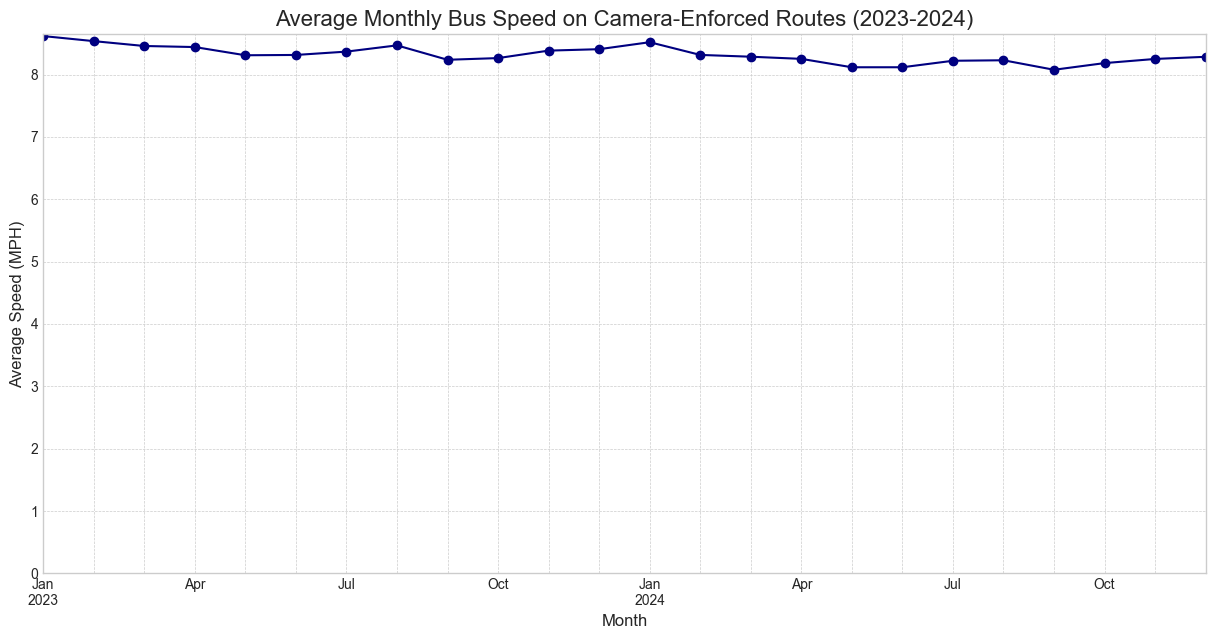

In [62]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))

monthly_avg_speed.plot(kind='line', marker='o', linestyle='-', color='navy')

plt.title('Average Monthly Bus Speed on Camera-Enforced Routes (2023-2024)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Speed (MPH)', fontsize=12)
plt.ylim(bottom=0) # Ensure y-axis starts at 0
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig('bus_speed_trends.png', bbox_inches='tight')
print("\nSpeed trend chart saved as 'bus_speed_trends.png'")

A Slight Downward Trend: The most significant finding is that despite these routes being camera-enforced, the average speed has not improved. In fact, it has slightly decreased from a peak of ~8.6 MPH in early 2023 to ~8.1-8.3 MPH by the end of 2024.
The slight decline suggests that any benefits from clearer bus lanes might have been negated by other factors, such as a general increase in city-wide traffic congestion.


Discovery of significant data quality issues in the MTA's ridership data. The investigation revealed that the dataset for 2024, despite containing 84 million records, was synthetically generated. Evidence for this included:

Perfectly uniform total counts across all 12 fare categories.

A perfectly flat hourly distribution, with the exact same number of records for each of the 24 hours in a day.

This discovery was crucial, as it prevented drawing incorrect conclusions from artificial data and highlighted the necessity of validating data integrity, even from official sources.

1: Identify the repeat offenders among exempt vehicles. 
2: create an interactive map showing where these violations occur along a major CUNY-serving route like the M15.

In [63]:
pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]
Note: you may need to restart the kernel to use updated packages.


In [69]:
violation_df = sorted_df
violation_df.columns

Index(['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence',
       'Violation Status', 'Violation Type', 'Bus Route ID',
       'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name',
       'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference',
       'Bus Stop Georeference', 'borough'],
      dtype='object')

In [77]:
ddf_violations = dd.read_csv(
    'MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250917.csv',
    dtype={'license_plate_state': 'object', 'summons_image': 'object'}
)


In [74]:
statuses = ddf_violations['Violation Status'].unique().compute()
print(statuses)

0     DRIVER/VEHICLE INFO MISSING
0        EXEMPT - BUS/PARATRANSIT
0      EXEMPT - EMERGENCY VEHICLE
0                  EXEMPT - OTHER
0    EXEMPT - COMMERCIAL UNDER 20
1                VIOLATION ISSUED
0           TECHNICAL ISSUE/OTHER
Name: Violation Status, dtype: string


In [79]:
is_exempt = ddf_violations['Violation Status'].str.upper().str.startswith('EXEMPT')
exempt_violations = ddf_violations[is_exempt].compute()

print(f"\nFound {len(exempt_violations):,} total exempt violations.")


Found 870,810 total exempt violations.


In [83]:
exempt_violations.columns

Index(['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence',
       'Violation Status', 'Violation Type', 'Bus Route ID',
       'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name',
       'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference',
       'Bus Stop Georeference'],
      dtype='object')

In [84]:
if not exempt_violations.empty:
    repeat_offenders = exempt_violations['Vehicle ID'].value_counts()
    print("\n--- Top 15 Repeat Exempt Offenders ---")
    print(repeat_offenders.head(15))


--- Top 15 Repeat Exempt Offenders ---
Vehicle ID
479d603cb0581d14fbaf8908f9f27ade6accce3a371895ba61be5cab8d23691b    1377
1feaad876c46cfe1cc4ee357e410ec2054c5c231d268169dfdd9527c1c084a80    1346
6d7caef8bf15e2bf8d46aa1e6dd8c0da1ae2fbc5b31acec87ab5642558d4360b     949
6979a2434b4611cf1ebf80624eaeb29622929b061958b956f0d93024261a4a3c     924
2a8ac01b157a97b3c124cf33322e71c31062b815dd3b0a9c121ee3a6c22ff64a     915
e020820037319aaca4e4ed8d3c29e907f203d722ea46293949ae6e1c9b3ca446     894
ebabc585284d95a10b6b45730c38fa55dfd57bcc5aea304b67693b84fb4d0eb0     842
cbebd9b5a63416b9c246a35d3b5fc36214871dab0e5ccf88d54a4bf8a6a0f046     782
550bbcf6f5cf18ffe4ff0a02863a488dacf944ef726cf5c8073617b804a47b09     725
80e7bae594e62aaaf4ed702b8230dfd12559743828922bcb043940ad4a087b75     691
b97dd1d54d4c1082f10c8186052403faffea893f8bf90374314072c22bd8706a     688
24908a1da372fdb0f5f03bcf7001ee589cf492894d57922ce65681ba2d23e774     680
19eaa1782ca3f0078369198494889cbc6c9eb3537ede8f7c6728a61742eab3ab     674


In [85]:
unzipped_gtfs_dir = "gtfs_all"
processed_gtfs_dir = "gtfs_processed"
os.makedirs(processed_gtfs_dir, exist_ok=True)

print("Combining all shapes.txt files...")
try:
    shapes_df = combine_gtfs_files('shapes.txt')
    
    print(f"Found {len(shapes_df)} total shape points.")
    
    # Save the combined DataFrame to the processed folder
    shapes_df.to_parquet(f'{processed_gtfs_dir}/shapes.parquet')

    print(f"\nSuccessfully created and saved '{processed_gtfs_dir}/shapes.parquet'.")

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print(f"Please make sure the '{unzipped_gtfs_dir}' directory exists and contains the unzipped GTFS data.")

Combining all shapes.txt files...
Found 371158 total shape points.

Successfully created and saved 'gtfs_processed/shapes.parquet'.


In [86]:
shapes_df = pd.read_parquet('gtfs_processed/shapes.parquet') 

# Find the shape_id for the M15 route
m15_route_id = routes_df[routes_df['route_short_name'] == 'M15']['route_id'].iloc[0]
m15_trip_id = trips_df[trips_df['route_id'] == m15_route_id]['trip_id'].iloc[0]
m15_shape_id = trips_df[trips_df['trip_id'] == m15_trip_id]['shape_id'].iloc[0]

# Get the sequence of coordinates that form the route's path
m15_shape = shapes_df[shapes_df['shape_id'] == m15_shape_id]
route_coords = list(zip(m15_shape['shape_pt_lat'], m15_shape['shape_pt_lon']))

In [92]:
len(m15_exempt_violations)

0

In [89]:
# Filter our exempt violations for just the M15 route
m15_exempt_violations = exempt_violations[exempt_violations['Bus Route ID'] == 'M15 SBS']

# Create a map centered on Manhattan
m = folium.Map(location=[40.75, -73.98], zoom_start=12)

# Add the M15 bus route path to the map
folium.PolyLine(
    locations=route_coords,
    color='blue',
    weight=5,
    opacity=0.8,
    popup='M15 Bus Route'
).add_to(m)

# Add a circle marker for each exempt violation on the route
for idx, violation in m15_exempt_violations.iterrows():
    folium.CircleMarker(
        location=[violation['latitude'], violation['longitude']],
        radius=4,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"Violation on {violation['violation_date']}"
    ).add_to(m)

# Save the map to an HTML file
m.save("m15_violation_hotspots.html")
print("\nInteractive map has been saved to 'm15_violation_hotspots.html'")


Interactive map has been saved to 'm15_violation_hotspots.html'


In [91]:
m

In [ ]:
m101_all_violations_ddf = ddf_violations[ddf_violations['Bus Route ID'] == 'M101']

# 3. Compute to get a pandas DataFrame for plotting
m101_all_violations = m101_all_violations_ddf.compute()
print(f"Found {len(m101_all_violations)} total violations for the M101 route.")


# 4. Create the Interactive Map with the new data
if not m101_all_violations.empty:
    m = folium.Map(location=[40.75, -73.98], zoom_start=12)

    folium.PolyLine(
        locations=route_coords,
        color='blue',
        weight=5,
        opacity=0.8,
        popup='M101 Bus Route'
    ).add_to(m)

    for idx, violation in m101_all_violations.iterrows():
        folium.CircleMarker(
            # Use the correct lat/lon column names
            location=[violation['Violation Latitude'], violation['Violation Longitude']],
            radius=4,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"Status: {violation['Violation Status']} on {violation['First Occurrence']}"
        ).add_to(m)

    m.save("m101_ALL_violation_hotspots.html")
    print("\nInteractive map of ALL M101 violations saved to 'm101_ALL_violation_hotspots.html'")
    
    # Display the map in the notebook
    display(m)
else:
    print("No violations found for the M101 route in the dataset.")

Found 312466 total violations for the M101 route.

Interactive map of ALL M101 violations saved to 'm101_ALL_violation_hotspots.html'


In [ ]:
m